<a href="https://colab.research.google.com/github/alla-g/careerfactory_23/blob/main/Data%20processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание
https://glebk.notion.site/25-2023-5818bea5801244c9bbab34648cfbf77d

HeadHunter - популярнейший сервис по поиску работы соискателем, а также поиска сотрудников работодателями.

Один из ключевых элементов сервиса — поисковое ядро, которое по запросу пользователя подбирает ему отранжированный список вакансий.  Пользователь может перейти в каждую вакансию на странице поисковой выдачи (SERP) и откликнуться на неё.

Мы в HeadHunter решили не отставать от времени и внедрить современные решения. У каждой вакансии на serp’е отображается краткое описание и логотип, который указывает компания-работодателя. Мы хотим попробовать заменить описание и логотип на автоматически сгенерированные с помощью нейронных сетей (типа ChatGPT и Midjourney), тем самым повысив привлекательность вакансии и увеличить количество откликов на нее.

Как data-driven компания, мы не запустим такую функцию без тестирования и выкатим её через A/B-тест.

**Ваша задача** — выбрать методологию и дизайн такого теста. Для этого нужно определить объект тестирования и принцип разделения на группы, а также рассчитать, какой эффект мы сможем статистически значимо отследить.

**В качестве целевой метрики в А/В используйте долю вакансий, у которых данный скор меньше определенного числа (пусть будет 3).**

Нужно учесть, что наш поиск — умный, и в алгоритме ранжирования в онлайне учитываются просмотры и отклики на каждую вакансию, сделанные за последние несколько дней/часов. Возможно, вам стоить знать, что как и любой поиск, у нас наблюдается position bias.

### Задание

1. Опишите методологию и дизайн теста. Почему сделали такой выбор?
    1. Определите объект тестирования и принцип разделения на группы.
    2. Рассчитайте, какой эффект можно статистически значимо отследить. Укажите его.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

## Загрузка и разведочный анализ

### Serp'ы

In [ ]:
!pip install gdown

In [ ]:
# для работы в колабе
!gdown https://drive.google.com/uc?id=1kikgAyfPvMqzwO5u4WP0Jg7xcpJzPWwI

Downloading...
From: https://drive.google.com/uc?id=1kikgAyfPvMqzwO5u4WP0Jg7xcpJzPWwI
To: /content/serps.csv
100% 125M/125M [00:01<00:00, 83.8MB/s]


In [ ]:
serp_df = pd.read_csv('serps.csv')

In [ ]:
serp_df

,request_id,vacancy_id_conv,city,applicant
0,168719525526659303f2dee867dc6eda,48019,Moscow,78076
1,168719525526659303f2dee867dc6eda,45120,Moscow,614859
2,168719525526659303f2dee867dc6eda,18132,Moscow,175212
3,168719525526659303f2dee867dc6eda,29942,Moscow,322643
4,168719525526659303f2dee867dc6eda,32658,Moscow,722260
...,...,...,...,...
2431591,16871839548434b4f62891daa5d10fd3,1102,Samara,156365
2431592,1687164459878871f4f0832e5fb53b5f,5170,Samara,615232
2431593,1687153595384444d2da11ecd811f7c4,8001,Samara,478614
2431594,168716903797271e492f2306df102cf8,28428,Samara,901182


In [ ]:
# переведём id реквестов, вакансий и соискателей в строки, чтобы посчитать статистику

serp_df['request_id'] = serp_df['request_id'].astype('string')
serp_df['vacancy_id_conv'] = serp_df['vacancy_id_conv'].astype('string')
serp_df['applicant'] = serp_df['applicant'].astype('string')

In [ ]:
serp_df.describe(include='all')

,request_id,vacancy_id_conv,city,applicant
count,2431596,2431596,2431596,2431596
unique,1000000,55500,5,911862
top,1687161453850e0bd12d3e10d9dbf2d3,13960,Moscow,903199
freq,50,22899,785767,12


**request_id** - миллион уникальных поисковых выдач, самая длинная содержит 50 вакансий

**vacancy_id_conv** - 55 500 уникальных вакансий, число совпадает с таблицей метрик

**city** - всего 5 городов, самый популярный город Москва

**applicant** - 911 862 уникальных соискателя, самый интересующийся видел 12 разных serp'ов

In [ ]:
serp_df['city'].value_counts()

Moscow    785767
SPb       592298
Kazan     456466
Penza     347974
Samara    249091
Name: city, dtype: int64

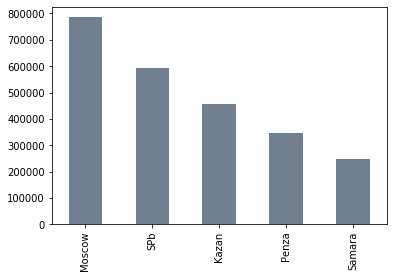

In [ ]:
serp_df['city'].value_counts().plot(kind='bar', color='slategrey')
plt.show()

Посмотрим, как распределена длина serp'ов (длина serp'а - количество вакансий, которые к ней относятся)

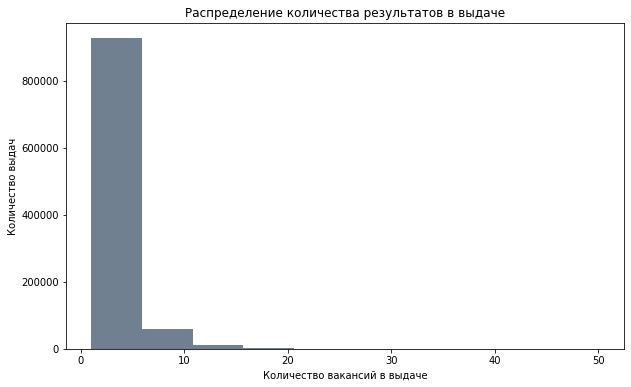

In [ ]:
plt.figure(figsize=(10,6))

serp_df.groupby(['request_id'])['request_id'].agg('count').plot.hist(color='slategrey')

plt.title('Распределение количества результатов в выдаче')
plt.xlabel('Количество вакансий в выдаче')
plt.ylabel('Количество выдач')
plt.show()

In [ ]:
pd.DataFrame(serp_df.groupby(['request_id'])['request_id'].agg('count')).describe()

,request_id
count,1000000.000000
mean,2.431596
std,2.290122
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,50.000000


Максимальная длина выдачи - 50 вакансий, но такое встречается очень редко. Большинство выдач содержат от 1 до 5 вакансий, в среднем 2.4

### Метрики

In [ ]:
# для работы в колабе
!gdown https://drive.google.com/uc?id=19Qmn2IyTx7M7R-P1m8yA_OPQ1D1aTyIx

Downloading...
From: https://drive.google.com/uc?id=19Qmn2IyTx7M7R-P1m8yA_OPQ1D1aTyIx
To: /content/vacs_metrics (1).csv
100% 1.60M/1.60M [00:00<00:00, 141MB/s]


In [ ]:
metrics_df = pd.read_csv('vacs_metrics (1).csv')

In [ ]:
metrics_df

,vacancy_id_conv,metric_full,emplpyer_id
0,1,5.250818,640
1,2,5.808587,5123
2,3,2.830297,3325
3,4,5.179469,3511
4,5,5.457955,6604
...,...,...,...
55495,58338,2.825501,1900
55496,58339,0.842977,2173
55497,58342,-0.628653,1110
55498,58343,1.892471,9611


In [ ]:
# переведём id вакансий и метрик в строки, чтобы посчитать статистику

metrics_df['vacancy_id_conv'] = metrics_df['vacancy_id_conv'].astype('string')
metrics_df['employer_id'] = metrics_df['emplpyer_id'].astype('string')  # заодно переименуем
metrics_df.drop(['emplpyer_id'], axis=1, inplace=True)

In [ ]:
metrics_df.describe(include='string')

,vacancy_id_conv,employer_id
count,55500,55500
unique,55500,9961
top,44454,798
freq,1,18


In [ ]:
metrics_df.describe()

,metric_full
count,55500.000000
mean,4.393625
std,1.430828
min,-2.259488
25%,3.609140
50%,4.562120
75%,5.372227
max,8.949871


**vacancy_id_conv** - колонка валидна, все id уникальны, встречаются строго по одному разу. Дубликатов вакансий нет

**employer_id** - колонка валидна, всего 9961 уникальный работодатель, самый популярный имеет 18 вакансий

**metric_full** - метрика принимает значения от -2.26 до 8.95, среднее значение 4.39

Отметим заданное пороговое значение метрики - 3

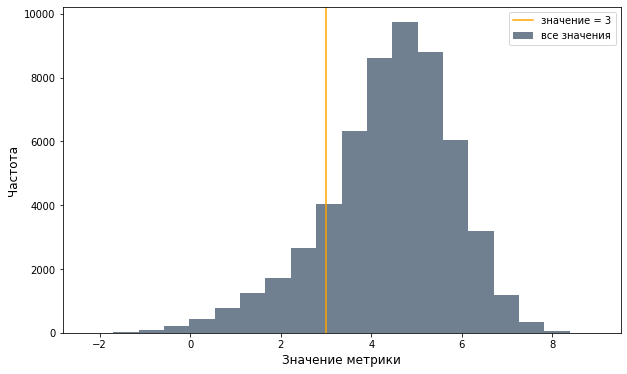

In [ ]:
plt.figure(figsize=(10,6))

metrics_df['metric_full'].plot.hist(bins = 20, color='slategrey', label='все значения')

plt.axvline(x=3, color='orange', label='значение = 3')
plt.xlabel('Значение метрики', fontsize='large')
plt.ylabel('Частота', fontsize='large')
plt.legend()
plt.show()

In [ ]:
print(f"Процент \"плохих\" вакансий: {round(len(metrics_df[metrics_df['metric_full'] < 3]) / len(metrics_df) * 100, 2)}%")
print(f"Процент \"хороших\" вакансий: {round(len(metrics_df[metrics_df['metric_full'] >= 3]) / len(metrics_df) * 100, 2)}%")

Процент "плохих" вакансий: 15.31%
Процент "хороших" вакансий: 84.69%


## Проверка на нормальность

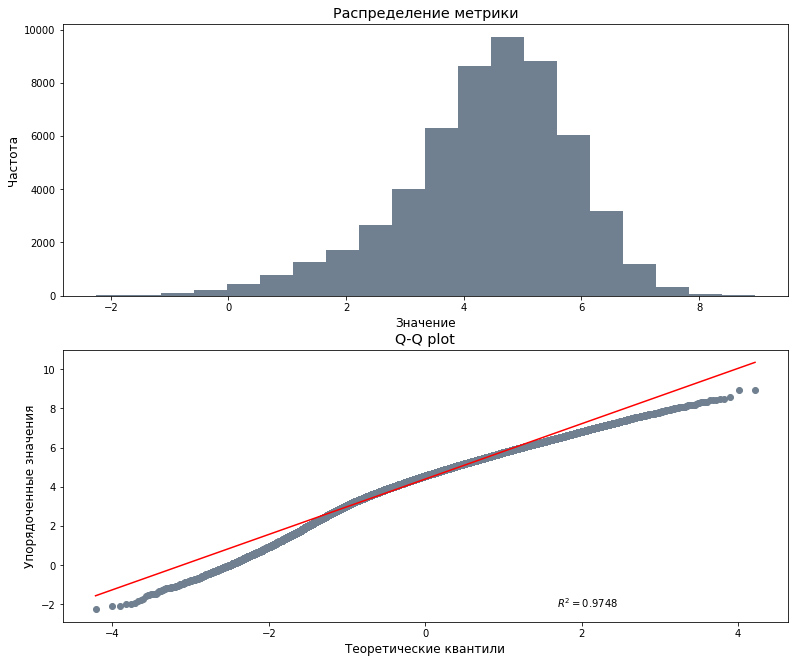

In [ ]:
# qq plot

sample = metrics_df['metric_full']

fig = plt.figure(figsize=(13,11))
ax = fig.add_subplot(211)
plt.hist(sample, bins = 20, color='slategrey')
plt.title('Распределение метрики', fontsize='x-large')
plt.xlabel('Значение', fontsize='large')
plt.ylabel('Частота', fontsize='large')

ax2 = fig.add_subplot(212)
stats.probplot(sample, dist = "norm", plot = plt, fit=True, rvalue=True)
plt.title('Q-Q plot', fontsize='x-large')
plt.ylabel('Упорядоченные значения', fontsize='large')
plt.xlabel('Теоретические квантили', fontsize='large')
ax2.get_lines()[0].set_markerfacecolor('slategrey')
ax2.get_lines()[0].set_markeredgecolor('slategrey')

plt.show()

In [ ]:
stats.shapiro(sample)

(0.9747731685638428, 0.0)

Результат 0.97 позволяет считать, что наше распределение достаточно приближено к нормальному

## Расчёт параметров теста

In [ ]:
import math
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.power import NormalIndPower

In [ ]:
alpha = 0.05
power = 0.8

power_analysis = NormalIndPower()

In [ ]:
less_than_3 = metrics_df[metrics_df['metric_full'] < 3]
less_than_3.head(5)

,vacancy_id_conv,metric_full,employer_id
2,3,2.830297,3325
36,37,2.718547,5685
51,52,2.840717,4405
58,59,2.770307,5415
60,61,0.789023,5325


### По заданному размеру выборки

In [ ]:
sample_size = 100 # задаётся менеджером

effect_size = power_analysis.solve_power(nobs1=sample_size, power=power, alpha=alpha, alternative='two-sided')
effect_size

0.39620357647695037

In [ ]:
# переводим MDE в разницу в абсолютных процентах (+5% или -5%)

current_share = len(less_than_3) / len(metrics_df)

min_effect = (math.sin(math.asin(math.sqrt(current_share)) - (effect_size / 2)) ** 2) - current_share
print(round(min_effect, 3)) # в процентах

-0.112


In [ ]:
# подставим обратно для проверки

current_share = len(less_than_3) / len(metrics_df)
min_effect = -0.112 # минимальный значимый результат в процентах

effect_size = proportion_effectsize(current_share, current_share + min_effect)
effect_size

0.39567188781969626

#### Визуализируем взаимосвязь MDE и размера выборки:

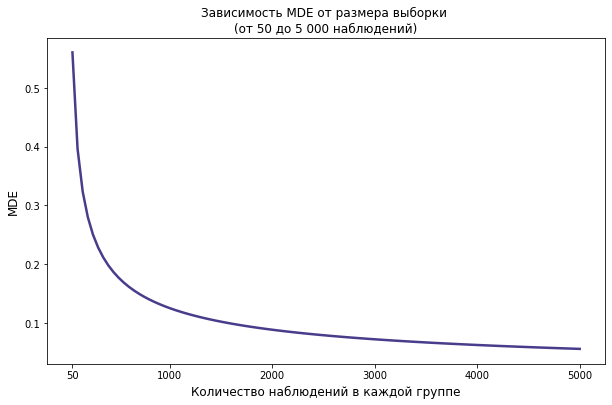

In [ ]:
sample_sizes = list(range(50, 5001, 50))

effect_sizes = [power_analysis.solve_power(nobs1=sample_size, power=power, alpha=alpha, alternative='two-sided')
                for sample_size in sample_sizes]

plt.figure(figsize=(10,6))
ax = plt.axes()

plt.plot(sample_sizes, effect_sizes, color='darkslateblue', linewidth=2.5)
plt.title('Зависимость MDE от размера выборки \n(от 50 до 5 000 наблюдений)', fontsize='large')
plt.xlabel('Количество наблюдений в каждой группе', fontsize='large')
plt.ylabel('MDE', fontsize='large')
ax.set_xticks([50, 1000, 2000, 3000, 4000, 5000])

plt.show()

### По заданному минимальному эффекту

In [ ]:
current_share = len(less_than_3) / len(metrics_df)
min_effect = 0.05 # минимальный значимый результат в процентах (+5%)

effect_size = proportion_effectsize(current_share, current_share + min_effect)

effect_size

-0.13096861747882615

In [ ]:
sample_size = power_analysis.solve_power(effect_size, power=power, alpha=alpha, alternative='two-sided')

sample_size = math.ceil(sample_size)
sample_size

916

## A/A тест

Проверим, что выбранный метод показывает ожидаемую точность и мощность. Для этого проведём тестирование на выборках из данных до вмешательства. Ожидаем, что при альфа=0,05 в 95% случаев тест не отвергнет нулевую гипотезу об отсутствии различий.

In [ ]:
# делаем первую выборку

a_sample, b_sample = metrics_df['metric_full'].sample(sample_size), metrics_df['metric_full'].sample(sample_size)

assert len(a_sample) == len(b_sample)

In [ ]:
a = [1 if value < 3 else 0 for value in a_sample]
b = [1 if value < 3 else 0 for value in b_sample]

In [ ]:
# проводим тест для неё

from statsmodels.stats.proportion import proportions_ztest

count = [sum(a), sum(b)]
nobs = [len(a), len(b)]

proportions_ztest(count, nobs, alternative='larger')

(0.4578783630150421, 0.32351991627693727)

P-value больше, чем 0.05, поэтому нет оснований отвергнуть гипотезу о равенстве доли метрик со значением < 3 в каждой из выборок. Теперь симулируем такую проверку несколько раз, чтобы убедиться в надёжности теста и параметров

In [ ]:
def simulate_tests(number_of_simulations):

    p_values = []

    for i in range(number_of_simulations):

        a_sample, b_sample = metrics_df['metric_full'].sample(sample_size), metrics_df['metric_full'].sample(sample_size)
        assert len(a_sample) == len(b_sample)

        a = [1 if value < 3 else 0 for value in a_sample]
        b = [1 if value < 3 else 0 for value in b_sample]

        count = [sum(a), sum(b)]
        nobs = [len(a), len(b)]

        z, p = proportions_ztest(count, nobs, alternative='larger')

        p_values.append(p)

    return p_values

In [ ]:
p_values = simulate_tests(1000)
rejections = [1 if p < 0.05 else 0 for p in p_values]  # сколько раз ошибочно отвергли H0

In [ ]:
from statsmodels.stats.proportion import proportion_confint

p_alpha = sum(rejections) / len(rejections) # доля ошибок первого рода
ci_lower, ci_higher = proportion_confint(sum(rejections),  len(rejections), alpha=0.05, method='normal')

print(f'Число ошибок первого рода: {sum(rejections)}')
print(f'Доля ошибок первого рода (оценка вероятности такой ошибки): {p_alpha}')
print(f'ДИ для вероятности ошибки первого рода: [{round(ci_lower, 3)}; {round(ci_higher, 3)}]')

Число ошибок первого рода: 42
Доля ошибок первого рода (оценка вероятности такой ошибки): 0.042
ДИ для вероятности ошибки первого рода: [0.03; 0.054]


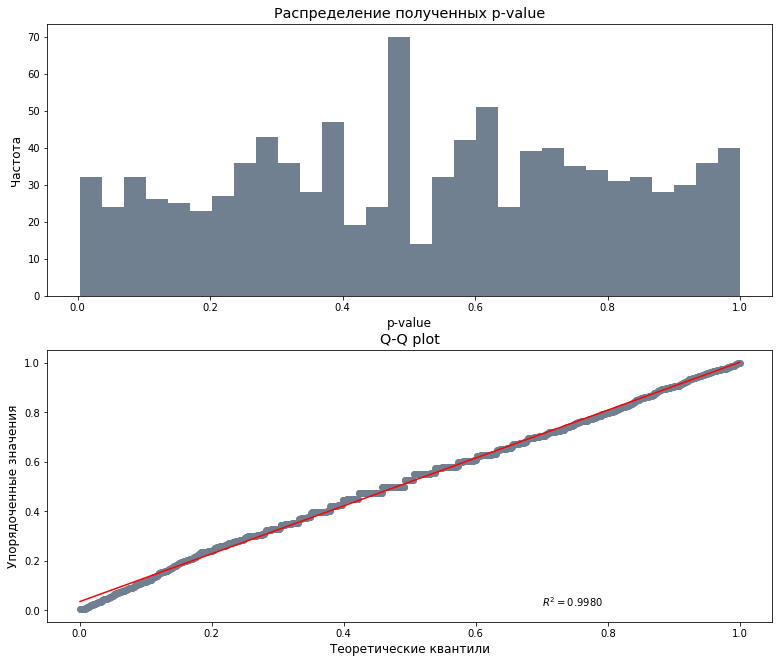

In [ ]:
# qq plot

fig = plt.figure(figsize=(13,11))
ax = fig.add_subplot(211)
plt.hist(p_values, bins=30, color='slategrey')
plt.title('Распределение полученных p-value', fontsize='x-large')
plt.xlabel('p-value', fontsize='large')
plt.ylabel('Частота', fontsize='large')

ax2 = fig.add_subplot(212)
stats.probplot(p_values, dist="uniform", plot=plt, fit=True, rvalue=True)
plt.title('Q-Q plot', fontsize='x-large')
plt.ylabel('Упорядоченные значения', fontsize='large')
plt.xlabel('Теоретические квантили', fontsize='large')
ax2.get_lines()[0].set_markerfacecolor('slategrey')
ax2.get_lines()[0].set_markeredgecolor('slategrey')

plt.show()

Доля ошибок первого рода находится в нужных пределах, а полученные p-value распределены равномерно, что позволяет признать дизайн нашего теста надёжным

### Код приложения streamlit:

In [ ]:
import math
import streamlit as st
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

power_analysis = NormalIndPower()

st.set_page_config(page_title="Калькулятор А/Б теста",
                   page_icon=':abacus:')

st.title('Калькулятор минимального эффекта и размера выборки')
st.subheader('Выберите тип калькулятора:')

tab1, tab2 = st.tabs(['Минимальный эффект по размеру выборки', 'Размер выборки по минимальному эффекту'])

with tab1:
    alpha1 = 0.05
    power1 = 0.8

    st.write("Уровень значимости: 0.05")
    st.write("Мощность: 0.8")

    size = st.slider("Размер каждой группы в выборке:", min_value=10, max_value=30000, value=100, key='s1')
    mde = power_analysis.solve_power(nobs1=size, alpha=alpha1, power=power1,
                                     ratio=1, alternative='two-sided')

    st.metric(label="Минимальный детектируемый эффект:", value=round(mde, 4))
    uplift = (math.sin(math.asin(math.sqrt(0.1531)) - (mde / 2)) ** 2) - 0.1531
    st.metric(label="Для текущего значения в 15,31% \"плохих\" вакансий минимальная абсоютная разница (± n%) составит:",
              value=f"{round(abs(uplift) * 100, 2)}%")

with tab2:
    alpha2 = 0.05
    power2 = 0.8

    st.write("Уровень значимости: 0.05")
    st.write("Мощность: 0.8")

    uplift2 = st.slider("Минимальная абсолютная разница в процентах (± n%):", min_value=0.1, max_value=100.0,
                        value=5.0, key='u2')
    mde2 = proportion_effectsize(0.1531, 0.1531 + uplift2 / 100)
    st.write("MDE составит:", abs(mde2))

    sample_size = power_analysis.solve_power(effect_size=mde2, alpha=alpha2, power=power2,
                                             ratio=1, alternative='two-sided')

    st.metric("Минимальный размер каждой группы в выборке:", math.ceil(sample_size))